In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
DATA_DIR = "data/train"
DOMAIN_A_DIR = "data/train/A"
DOMAIN_B_DIR = "data/train/B"

In [4]:
PROCESS_DATA = 1
TRAIN_DATA = 1
IMG_SIZE = 200
BATCH_SIZE = 1

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
if PROCESS_DATA:
    dataset_A = datasets.ImageFolder(DOMAIN_A_DIR, transform=data_transform)
    dataloader_A = data.DataLoader(dataset_A, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)
    dataset_B = datasets.ImageFolder(DOMAIN_B_DIR, transform=data_transform)
    dataloader_B = data.DataLoader(dataset_B, batch_size=BATCH_SIZE, num_workers= 2, shuffle= True)

In [7]:
print("Domain A size: {}".format(len(dataset_A)))
print("Domain B size: {}".format(len(dataset_B)))

Domain A size: 1067
Domain B size: 1334


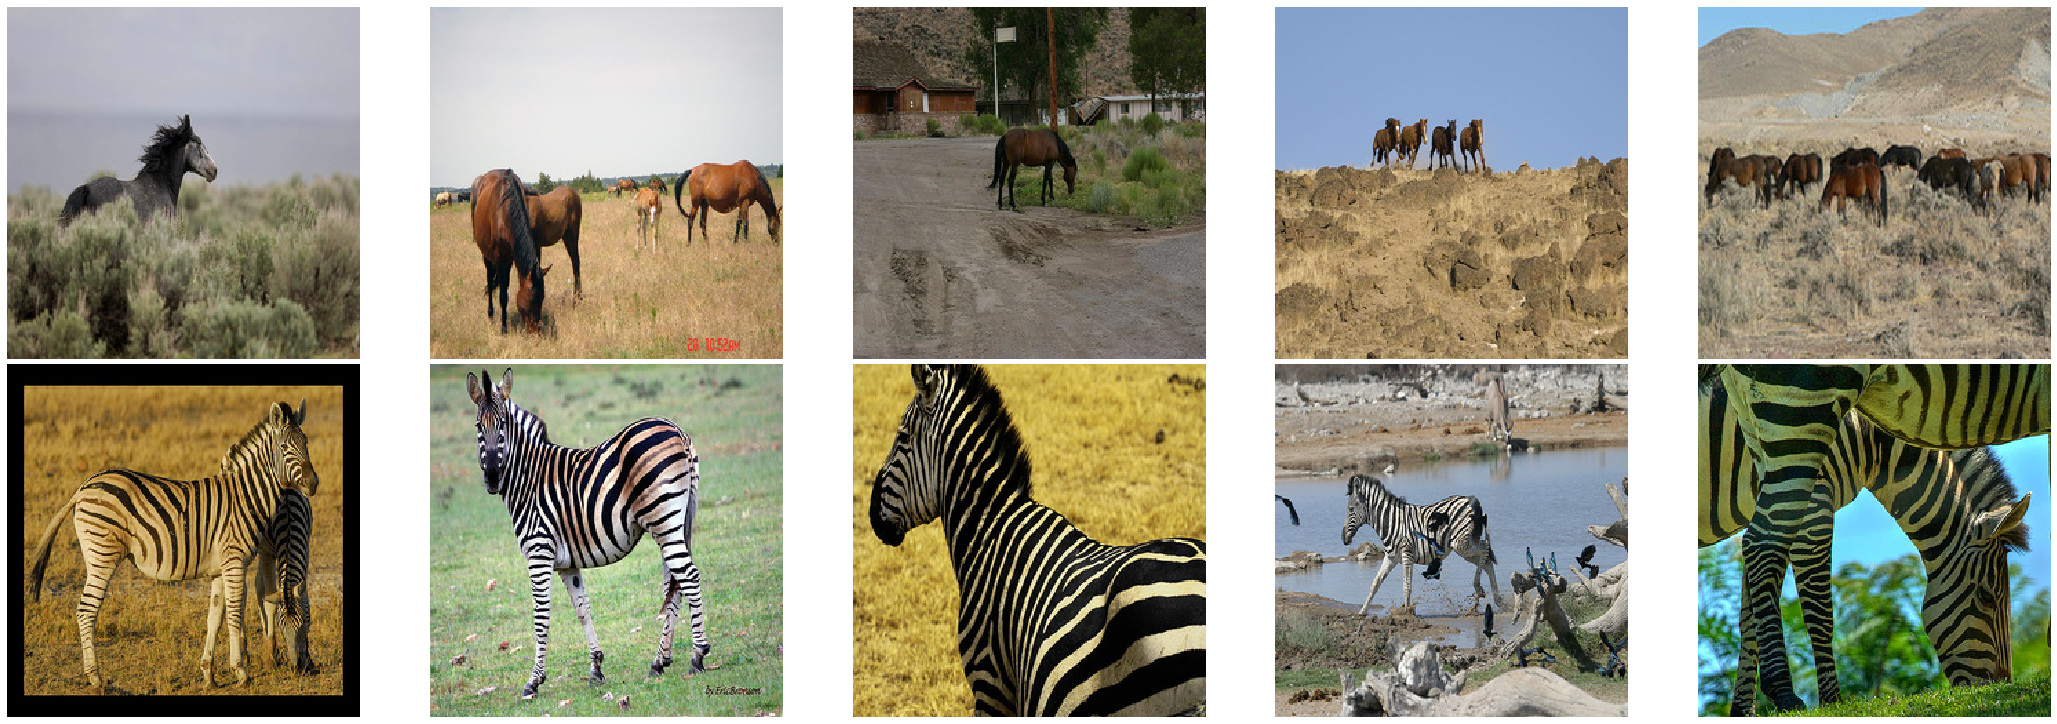

In [8]:
a = np.random.randint(1000)
fig = plt.figure(figsize=(30,10))
count = 1
for i in ["A/horse", "B/zebra"]:
    path = os.listdir(os.path.join(DATA_DIR, i))
    for f in path[a:a+5]:
        path1 = os.path.join(DATA_DIR, i,f)
        img = Image.open(path1)
        fig.add_subplot(2,5,count)
        plt.imshow(img)
        plt.axis("off")
        count+=1
fig.tight_layout(pad=0.5)   
plt.show()
        

In [9]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = np.random.uniform(0, 1)
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [10]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [11]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [12]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out

In [13]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

In [15]:
def generate_labels(size, label):
    if label == 1:
        data = torch.ones(size) - 0.1
    elif label == 0:
        data = torch.zeros(size)
    data = Variable(data).to(device)
    return data

In [16]:
def train_generator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    G_A2B.zero_grad()
    G_B2A.zero_grad()
    
    """ # Identity losses #
    replicate_B       = G_A2B(real_B)
    loss_identity_B   = cyclic_error(replicate_B, real_B) * 5
        
    replicate_A       = G_B2A(real_A)
    loss_identity_A   = cyclic_error(replicate_A, real_A) * 5"""
    
    # Transform losses #
    predict_fake_B = D_B(fake_B)
    loss_G_A = error(predict_fake_B,generate_labels(predict_fake_B.size(),1))
    
    predict_fake_A = D_A(fake_A)
    loss_G_B = error(predict_fake_A,generate_labels(predict_fake_A.size(),1))
    
    # Cycle losses #
    cyclic_A = G_B2A(fake_B)
    loss_cyclic_A = cyclic_error(real_A,cyclic_A) * 10
    
    cyclic_B = G_A2B(fake_A)
    loss_cyclic_B = cyclic_error(cyclic_B,real_B) *10
    
    # Total Losses #
    loss_G = loss_G_A + loss_G_B + loss_cyclic_A + loss_cyclic_B #+ loss_identity_A + loss_identity_B
    loss_G.backward()
    optimizer_A.step()
    optimizer_B.step()
    
    return loss_G_A.data, loss_G_B.data, loss_cyclic_A.data, loss_cyclic_B.data

In [17]:
fake_A_pool = ImagePool(50)
fake_B_pool = ImagePool(50)

In [18]:
def train_discriminator(D_A,D_B,G_A2B,G_B2A,optimizer_A,optimizer_B,error,cyclic_error,real_A, fake_A, real_B, fake_B):
    batch_size = real_A.size(0)
    D_A.zero_grad()
    D_B.zero_grad()
    
    #Train Discriminator A
    predict_real_A = D_A(real_A)
    loss_real_A = error(predict_real_A,generate_labels(predict_real_A.size(),1))
    
    fake_A = fake_A_pool.query(fake_A)
    
    predict_fake_A = D_A(fake_A)
    loss_fake_A = error(predict_fake_A,generate_labels(predict_fake_A.size(),0))
    
    loss_D_A = (loss_real_A +loss_fake_A)*5
    loss_D_A.backward()
    optimizer_A.step()
    
    #Train Discriminator B
    predict_real_B = D_B(real_B)
    loss_real_B = error(predict_real_B,generate_labels(predict_real_B.size(),1))
    
    fake_B = fake_B_pool.query(fake_B)
    
    predict_fake_B = D_B(fake_B)
    loss_fake_B = error(predict_fake_B,generate_labels(predict_fake_B.size(),0))
    
    loss_D_B = (loss_real_B +loss_fake_B)*5
    loss_D_B.backward()
    optimizer_B.step()
    
    return loss_D_A.data, loss_D_B.data
    
    

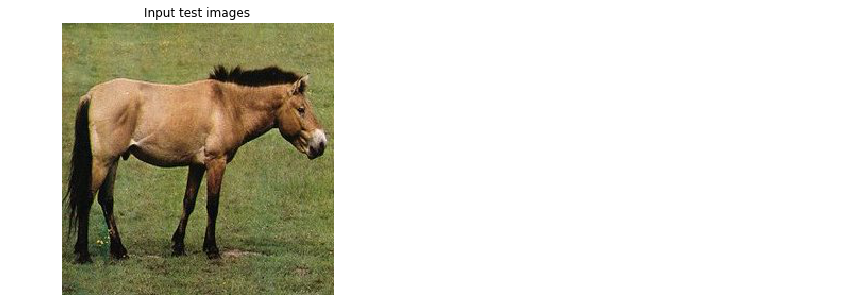

In [19]:
fixed_img_A = Image.open("data/test/testA/n02381460_3330.jpg")

fig = plt.figure(figsize=(15,5))
plt.axis("off")
fig.add_subplot(1,2,1)
plt.axis("off")
plt.title("Input test images")
plt.imshow(fixed_img_A)

plt.show()



In [20]:
transform_A = Variable(data_transform(fixed_img_A)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
#transform_B = Variable(data_transform(fixed_img_B)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)

In [21]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

In [22]:
def generate_img(G_A2B, G_B2A, img_A):
    G_A2B.eval()
    G_B2A.eval()
    
    
    with torch.no_grad():
        img_show = imshow(img_A)
        
        fake_B = G_A2B(img_A)
        fake_B_show = imshow(fake_B)
        
        fake_A = G_B2A(fake_B)
        fake_A_show = imshow(fake_A)
        
        
    fig = plt.figure(figsize=(30,10))
    plt.title("Generator test")
    plt.axis("off")
    fig.add_subplot(1,3,1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(img_show)
    fig.add_subplot(1,3,2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(fake_B_show)
    fig.add_subplot(1,3,3)
    plt.axis("off")
    plt.title("Reconstructed")
    plt.imshow(fake_A_show)
    
    plt.show()
    G_A2B.train()
    G_B2A.train()

In [23]:
nc = 3
ngf = 64
ndf = 64
num_resnet = 6

In [24]:
# input_dim, num_filter, output_dim, num_resnet
G_A2B = Generator(nc, ngf, nc, num_resnet).to(device)
G_B2A = Generator(nc, ngf, nc, num_resnet).to(device)
#generate_img(G_A2B,G_B2A,transform_A)
def train(dataloader_A, dataloader_B):
    
    # input_dim, num_filter, output_dim
    D_A = Discriminator(nc, ndf, 1).to(device)
    D_B = Discriminator(nc, ndf, 1).to(device)

    G_A2B.normal_weight_init(mean=0.0, std=0.02)
    G_B2A.normal_weight_init(mean=0.0, std=0.02)
    D_A.normal_weight_init(mean=0.0, std=0.02)
    D_B.normal_weight_init(mean=0.0, std=0.02)

    G_A_optimizer = torch.optim.Adam(
        G_A2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
    G_B_optimizer = torch.optim.Adam(
        G_B2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_A_optimizer = torch.optim.Adam(
        D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_B_optimizer = torch.optim.Adam(
        D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

    MSE_error = nn.MSELoss()
    L1_error = nn.L1Loss()

    D_A_loss_list = []
    D_B_loss_list = []
    G_A_loss_list = []
    G_B_loss_list = []
    Cyclic_A_loss_list = []
    Cyclic_B_loss_list = []

    EPOCHS = 30

    print("Start training...")
    for epoch in range(EPOCHS):
        for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):
            real_A = batch_A[0].to(device)
            real_B = batch_B[0].to(device)
            fake_A = G_B2A(real_A)
            fake_B = G_A2B(real_B)
            loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B = train_generator(D_A, D_B, G_A2B, G_B2A, G_A_optimizer, G_B_optimizer,
                                                                               MSE_error, L1_error, real_A, fake_A, real_B, fake_B)
            loss_D_A, loss_D_B = train_discriminator(D_A, D_B, G_A2B, G_B2A, D_A_optimizer, D_B_optimizer, MSE_error, L1_error, real_A,
                                                     fake_A, real_B, fake_B)

            D_A_loss_list.append(loss_D_A)
            D_B_loss_list.append(loss_D_B)
            G_A_loss_list.append(loss_G_A)
            G_B_loss_list.append(loss_G_B)
            Cyclic_A_loss_list.append(loss_cyclic_A)
            Cyclic_B_loss_list.append(loss_cyclic_B)

            if i % 360 == 0 or i == len(dataloader_A)-1:
                print("Epoch: ({}/{}) | Batch: ({}/{}) | D_A_Loss: {:.4f} D_B_Loss: {:.4f} | G_A_Loss: {:.4f} G_B_Loss: {:.4f} | C_A_Loss: {:.4f} C_B_Loss: {:.4f} |".format(
                    epoch+1, EPOCHS, i+1, len(dataloader_A), loss_D_A, loss_D_B, loss_G_A, loss_G_B, loss_cyclic_A, loss_cyclic_B))
        
        if epoch%3==0 or epoch == EPOCHS-1:
            ga_name = "model/generatorA-{}.pth".format(epoch)
            gb_name = "model/generatorB-{}.pth".format(epoch)
            torch.save(G_A2B.state_dict(), ga_name)
            torch.save(G_B2A.state_dict(), gb_name)
            generate_img(G_A2B, G_B2A, transform_A)
            
        if(epoch % 20 == 0 and epoch>0) :
            D_A_optimizer.param_groups[0]['lr'] -= 0.0002 / 100 
            D_B_optimizer.param_groups[0]['lr'] -= 0.0002 / 100 
            G_A_optimizer.param_groups[0]['lr'] -= 0.0002 / 100     
            G_B_optimizer.param_groups[0]['lr'] -= 0.0002 / 100
        
    print("Training Completed!")
    return G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list

In [ ]:
if TRAIN_DATA:
    G_A2B, G_B2A, D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list = train(
        dataloader_A, dataloader_B)
    

Start training...
Epoch: (1/30) | Batch: (1/1067) | D_A_Loss: 7.6793 D_B_Loss: 4.0390 | G_A_Loss: 0.6429 G_B_Loss: 1.3332 | C_A_Loss: 8.6361 C_B_Loss: 9.2981 |
Epoch: (1/30) | Batch: (361/1067) | D_A_Loss: 0.3145 D_B_Loss: 0.9396 | G_A_Loss: 0.6589 G_B_Loss: 0.5465 | C_A_Loss: 8.1595 C_B_Loss: 7.3379 |
Epoch: (1/30) | Batch: (721/1067) | D_A_Loss: 0.8816 D_B_Loss: 1.2686 | G_A_Loss: 0.3498 G_B_Loss: 1.1027 | C_A_Loss: 9.7488 C_B_Loss: 12.7865 |


In [ ]:
#Plot learning curves
def plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_A_loss_list)
    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(2,1,1)
    plt.plot(range(EPOCHS), D_A_loss_list,label = "Discriminator A Loss")
    plt.plot(range(EPOCHS),D_B_loss_list, color ="orange",label = "Discriminator B Loss")
    plt.plot(range(EPOCHS),G_A_loss_list, color ="cyan",label = "Gennerator A Loss")
    plt.plot(range(EPOCHS),G_B_loss_list, color ="red",label = "Gennerator B Loss")
    plt.title("Learning Curve 1")
    plt.legend()
    
    fig.add_subplot(2,1,2)
    plt.plot(range(EPOCHS), Cyclic_A_loss_list,label = "Cycle A Loss")
    plt.plot(range(EPOCHS), Cyclic_B_loss_list, color ="orange",label = "Cycle B Loss")
    plt.title("Learning Curve 2")
    plt.legend()
    plt.show()
if TRAIN_DATA: 
    plot(D_A_loss_list, D_B_loss_list, G_A_loss_list, G_B_loss_list, Cyclic_A_loss_list, Cyclic_B_loss_list)

In [ ]:
def test_generator(img,G_A2B,G_B2A, domain):
    img = Variable(data_transform(img)).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
    with torch.no_grad():
        img_show = imshow(img)
        if domain == "A":
            fake = G_A2B(img)
            fake_show = imshow(fake)
            reconstructed = G_B2A(fake)
            reconstructed_show = imshow(reconstructed)
        else:
            fake = G_B2A(img)
            fake_show = imshow(fake)
            reconstructed = G_A2B(fake)
            reconstructed_show = imshow(reconstructed)


    fig = plt.figure(figsize=(30,10))
    plt.title("Generator test")
    plt.axis("off")
    fig.add_subplot(1,3,1)
    plt.axis("off")
    plt.title("Real")
    plt.imshow(img_show)
    fig.add_subplot(1,3,2)
    plt.axis("off")
    plt.title("Generated")
    plt.imshow(fake_show)
    fig.add_subplot(1,3,3)
    plt.axis("off")
    plt.title("Reconstructed")
    plt.imshow(reconstructed_show)
    plt.show()
    
test_A = Image.open("data/test/testA/n02381460_4660.jpg")
test_B = Image.open("data/test/testB/n02391049_4890.jpg")

test_generator(test_A,G_A2B,G_B2A,"A")
test_generator(test_B,G_A2B,G_B2A,"B")